# CNN+CTC图像文本识别

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/application/zh_cn/cv/mindspore_cnnctc.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/application/zh_cn/cv/mindspore_cnnctc.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/application/source_zh_cn/cv/cnnctc.ipynb)

## 模型简介

### 文本识别流程介绍

文本识别指从图像中识别出文本，将图像中的文字区域转化为字符信息，通常采用CNN网络从图像中提取丰富的特征信息，然后根据提取的特征信息进行识别。这里采用ResNet作为特征提取网络，采用CTC方法进行识别。由于每张样本的字符数量不同，字符样式不同，字体大小也不同，导致每列的输出并不一定能与每个字符一一对应，CTC(Connectionist Temporal Classification)提出一种不需要对齐的Loss计算方法，用于训练网络。

模型实现的步骤如下：

1. 通过CNN（ResNet）提取文本图片中的Feature Map；
2. 对每张图片中的Feature Map 划分为不同的特征序列；
3. 对每个序列进行字符分类；
4. 使用CTC损失函数计算损失，CTC能够根据固定长度的特征序列预测非固定长度的标签。

整体流程图如下：

![算法流程图](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/cnnctc.png)


### CTC方法介绍

对于固定长度的输出和可变长度的标签数据，CTC提供了一种计算Loss的方法，用于训练网络参数。CTC的关键方法是预测每列的字符并通过删除重复和空白的字符将整个字符序列修改为非固定长度的字符流。步骤如下：

1. 获得定长的字符序列

    根据模型得到的序列在每个位置上的概率分布获得定长的字符序列。模型输出的序列$H = h_1$, . . . , $h_T$，其中$T$为序列长度，这个序列长度是固定的，$\pi$为根据序列的概率分布得到的字符序列，其概率定义为：

    $$
    p(\pi|H)=\prod_{t=1}^{T}{y^t_{\pi_t}}
    $$

    其中$y^t_{\pi_t}$为在每个时间步$t$生成字符$\pi_t$的概率。

2. 定长的字符序列变为非固定长度序列

    映射函数$M$，通过删除重复字符和空白，将$\pi$映射到$Y$。例如，对于‘aaa-dd-d-c-d---d’，映射函数$M$将其映射为‘addcdd’，其中‘-’表示空白。

3. 条件概率定义

    条件概率则定义为所有能够通过映射函数$M$映射到标签字符序列$Y$上的定长字符序列$\pi$的概率之和：

    $$
    p(Y|H)= \displaystyle \sum^{ }_{\pi:M(\pi)=Y}{P(\pi|H)}
    $$

4. 目标函数

    训练的目标是使得这个条件概率取得最大值，而且计算条件概率的过程只有加和乘操作，一定是可导的，故可以得到一个梯度来进行网络模型参数的更新，公式如下：

    $$
    p(Y|H)=- \displaystyle \sum^{ }_{X_i,Y_i\in TD}{logP(Y_i|X_i)}
    $$

    $TD$表示训练数据集。

5. 测试

    在进行测试的时候，在每个时间步，取具有最大概率的字符，来作为预测的标签序列，公式如下：

    $$
    Y^*\approx M(arg  max  P(\pi|H))
    $$


### ResNet网络介绍

残差神经网络(ResNet)是由微软研究院的何恺明、张祥雨、任少卿、孙剑等人提出的，并在2015 年的ILSVRC（ImageNet Large Scale Visual Recognition Challenge）比赛中取得了冠军。残差神经网络的主要贡献是提出了了 “快捷连接（Shortcut Connection）”，极大的改善网络的“退化现象（Degradation）”，有效的缓解了较深的神经网络在训练过程中的梯度消失问题，从而实现更深的网络结构设计，提高了模型的精度。

1. 残差网络结构

    残差网络结构由两个分支构成：一个主分支，一个Shortcuts。主分支通过堆叠一系列卷积操作得到，Shortcuts从输入直接到输出，主分支得到的输出加上Shortcuts得到的输出，通过ReLU激活函数后即为残差网络最后的输出。

    这里使用的残差网络结构，主分支有两层卷积网络结构：

    - 第一层网络，Kernel_size为3的卷积层 + BatchNorm + ReLU；
    - 第二层网络，Kernel_size为3的卷积层 + BatchNorm。

    最后将主分支输出的特征矩阵与Shortcuts输出的特征矩阵相加，通过ReLU激活函数即为残差网络结构的最终输出。

2. ResNet网络结构

    这里的ResNet由5层网络结构组成：

    - 第一层，Kernel_size为3的卷积层 + BatchNorm + Kernel_size为3的卷积层 + BatchNorm + Relu；
    - 第二层，最大池化 + 残差网络 + Kernel_size为3的卷积层 + BatchNorm；
    - 第三层，最大池化 + 残差网络 + Kernel_size为3的卷积层 + BatchNorm；
    - 第四层，最大池化 + 残差网络 + Kernel_size为3的卷积层 + BatchNorm；
    - 第五层， 残差网络 + Kernel_size为2的卷积层 + BatchNorm + Kernel_size为2的卷积层 + BatchNorm。


## 数据集

### 数据集介绍

为了使得训练的结果更具有说明性，采用了多个数据集进行训练，在训练之前需要将多个数据集合并为一个数据集；同时数据集中每条数据的标签长度不一，为了达到更好的训练效果，希望每次训练的数据的标签长度都一致，在提取数据的时候需要按照一定的索引进行提取。

本案例使用[MJSynth](https://www.robots.ox.ac.uk/~vgg/data/text/)和[SynthText](https://github.com/ankush-me/SynthText)数据集用于模型训练，[The IIIT 5K-word dataset](https://cvit.iiit.ac.in/research/projects/cvit-projects/the-iiit-5k-word-dataset)数据集用于测试。

- MJSynth（MJ）

    MJ是一个为STR设计的合成数据集，包含8.9M个单词框图像。单词框生成过程如下：

    1. 字体渲染；
    2. 边框和阴影渲染；
    3. 背景着色；
    4. 字体、边框和背景的合成；
    5. 应用投影失真；
    6. 与真实图像混合；
    7. 添加噪声。

- SynthText（ST）

    ST是另一个合成产生的数据集，最初设计用于场景文本检测。尽管ST是为场景文本检测任务设计的，但它也可以通过裁剪单词框用于场景文字识别(Scene Text Recognition, STR)。通过对数据集的单词框进行裁剪获得了5.5 M个单词文本图像。

- IIIT5K Words（IIIT）

    IIIT是从Google图像搜索中抓取的数据集，其中包含可能返回文本图像的查询词，例如“广告牌”、“招牌”、“门牌号”、“门牌号”和“电影海报”。IIIT包括2000张用于训练的图像和3000张用于评估的图像。

### 数据集合并及索引生成

- 数据集合并

    依次打开数据集的lmdb文件，读取图片和标签，并写入同一个新的lmdb文件中。

- 分析新数据集中的标签的长度分布以及组合

    在一个Batch中所有数据的Label总长度固定的情况下，得到Batch中组成数据的Label的长度的可能组合。首先得到每条数据中标签的长度，获取数据集中各种标签长度的分布情况，以及数据集中所有标签的总长度，然后根据数据计算出每个Batch中的标签的平均长度，最后根据Batch中的平均长度以及各种标签长度的分布情况，获得可能的组合，使得每个Batch的平均长度相同。

- 根据标签组合得到一个索引表

    根据获取的可能组合，形成训练时采集数据的索引列表。这里有超参数可以控制实际训练数据集的大小，在采样过程中，根据标签长度组合随机选择，故超参可设置稍大一些，目的是尽可能将数据集中所有数据都采集到。


### 数据集下载

使用download模块对数据集进行下载和解压。数据下载之前需要使用```pip install download```安装download包。

In [1]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cnnctc_dataset.tar.gz"

download(url, ".", kind="tar.gz", replace=True)


file_sizes: 100%|████████████████████████████| 572M/572M [08:38<00:00, 1.10MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to .


'.'

## 模型构建

这边模型构建分三个部分，具体如下：

1. 采用ResNet网络从图片中提取特征；
2. 将每张图片提取的Feature Map划分为不同的序列Feature；
3. 对每个序列Feature进行预测，得到该序列属于不同字符的概率。

In [2]:
from mindspore import nn
from mindspore.common.initializer import TruncatedNormal


class CNNCTC(nn.Cell):
    def __init__(self, num_class, hidden_size, final_feature_width):
        super(CNNCTC, self).__init__()

        self.num_class = num_class
        self.hidden_size = hidden_size
        self.final_feature_width = final_feature_width

        self.feature_extraction = ResNet(3, 512, BasicBlock, [1, 2, 5, 3])
        self.prediction = nn.Dense(self.hidden_size, self.num_class)

    def construct(self, x):
        x = self.feature_extraction(x)
        # 进行维度转换，方便划分图片时按列划分
        x = ops.transpose(x, (0, 3, 1, 2))  # [b, c, h, w] -> [b, w, c, h]
        x = ops.reshape(x, (-1, self.hidden_size))
        x = self.prediction(x)
        x = ops.reshape(x, (-1, self.final_feature_width, self.num_class))

        return x


class ResNet(nn.Cell):
    def __init__(self, input_channel, output_channel, block, layers):
        super(ResNet, self).__init__()

        self.output_channel_block = [int(output_channel / 4), int(output_channel / 2), output_channel, output_channel]
        self.inplanes = int(output_channel / 8)

        self.conv0_1 = nn.Conv2d(input_channel, int(output_channel / 16), kernel_size=3, stride=1, padding=1,
                                 pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn0_1 = nn.BatchNorm2d(int(output_channel / 16), momentum=0.1)
        self.conv0_2 = nn.Conv2d(int(output_channel / 16), self.inplanes, kernel_size=3, stride=1, padding=1,
                                 pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn0_2 = nn.BatchNorm2d(self.inplanes, momentum=0.1)
        self.relu = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='valid')
        self.layer1 = self._make_layer(block, self.output_channel_block[0], layers[0])
        self.conv1 = nn.Conv2d(self.output_channel_block[0], self.output_channel_block[0], kernel_size=3, stride=1,
                               padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn1 = nn.BatchNorm2d(self.output_channel_block[0], momentum=0.1)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='valid')
        self.layer2 = self._make_layer(block, self.output_channel_block[1], layers[1])
        self.conv2 = nn.Conv2d(self.output_channel_block[1], self.output_channel_block[1], kernel_size=3, stride=1,
                               padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn2 = nn.BatchNorm2d(self.output_channel_block[1], momentum=0.1)
        self.pad = nn.Pad(((0, 0), (0, 0), (0, 0), (2, 2)))

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=(2, 1), pad_mode='valid')
        self.layer3 = self._make_layer(block, self.output_channel_block[2], layers[2])
        self.conv3 = nn.Conv2d(self.output_channel_block[2], self.output_channel_block[2], kernel_size=3, stride=1,
                               padding=1, pad_mode='pad', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn3 = nn.BatchNorm2d(self.output_channel_block[2], momentum=0.1)

        self.layer4 = self._make_layer(block, self.output_channel_block[3], layers[3])
        self.conv4_1 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[3], kernel_size=2,
                                 stride=(2, 1), padding=0, pad_mode='valid', weight_init=TruncatedNormal(0.02),
                                 has_bias=False)
        self.bn4_1 = nn.BatchNorm2d(self.output_channel_block[3], momentum=0.1)
        self.conv4_2 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[3], kernel_size=2, stride=1,
                                 padding=0, pad_mode='valid', weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn4_2 = nn.BatchNorm2d(self.output_channel_block[3], momentum=0.1)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.SequentialCell(
                [nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, padding=0,
                           pad_mode='same', weight_init=TruncatedNormal(0.02), has_bias=False),
                 nn.BatchNorm2d(planes * block.expansion, momentum=0.1)]
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv0_1(x)
        x = self.bn0_1(x)
        x = self.relu(x)
        x = self.conv0_2(x)
        x = self.bn0_2(x)
        x = self.relu(x)

        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool2(x)
        x = self.layer2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.maxpool3(x)
        x = self.layer3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.layer4(x)
        x = self.pad(x)
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.relu(x)

        return x


class BasicBlock(nn.Cell):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, pad_mode='pad',
                               weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=0.1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, pad_mode='pad',
                               weight_init=TruncatedNormal(0.02), has_bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=0.1)
        self.relu = nn.ReLU()
        self.downsample = downsample

    def construct(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out = ops.add(out, residual)
        out = self.relu(out)

        return out

## 动态学习率

根据训练的步数，设置学习率，在warmup_steps以内的，学习率线性改变；在warmup_steps之后的，学习率改变符合余弦分布。

In [3]:
# 实现动态学习率
import math

def dynamic_lr(steps_per_epoch, base_lr, warmup_ratio, warmup_step, epochs):
    total_steps = steps_per_epoch * epochs
    warmup_steps = int(warmup_step)
    decay_steps = total_steps - warmup_steps
    lr = []
    for i in range(total_steps):
        if i < warmup_steps:
            lr_inc = (float(base_lr) - float(base_lr * warmup_ratio)) / float(warmup_steps)
            learning_rate = float(base_lr * warmup_ratio) + lr_inc * i
            lr.append(learning_rate)
        else:
            base = float(i - warmup_steps) / float(decay_steps)
            learning_rate = (1 + math.cos(base * math.pi)) / 2 * base_lr
            lr.append(learning_rate)
    return lr

## 模型训练

接下来建训练过程。

使用函数式自动微分，需先定义前向过程函数forward_fn，使用mindspore.value_and_grad获得微分函数grad_fn。然后，我们将微分函数和优化器的执行封装为train_step函数，接下来循环迭代数据集进行训练。

> 本案例当前仅支持在Ascend/CPU设备上以动态图模式运行，其他设备和运行模式将在后续的版本中支持。

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
import mindspore as ms
from mindspore import ops, ParameterTuple, Tensor
from mindspore.common import dtype
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.dataset import MindDataset

device_target = 'CPU'
train_dataset_path = './cnnctc_dataset/STMJ_train_dataset.mindrecord'
batch_size = 64
epochs = 5
pred_trained = ''
final_feature_width = 26
num_class = 37
hidden_size = 512

ms.set_context(device_target=device_target, mode=ms.PYNATIVE_MODE)

# 数据集加载
data = MindDataset(dataset_files=train_dataset_path)
dataset_size = data.get_dataset_size()
print('dataset_size:', dataset_size)
print('batch_size:', batch_size)

# 模型初始化
net = CNNCTC(num_class, hidden_size, final_feature_width)

# 加载预训练权重
if pred_trained:
    param_dict = load_checkpoint(pred_trained)
    load_param_into_net(net, param_dict)
    print('Pred_trained parameters loaded!')

# 损失函数
loss_fn = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=False)

# 学习率
lr = Tensor(dynamic_lr(dataset_size // batch_size, 0.0005, 0.0625, 2000, epochs), dtype.float32)
lr = lr[::-1]

# 优化器
opt = nn.RMSProp(params=net.trainable_params(),
                 centered=True,
                 learning_rate=lr,
                 momentum=0.8)

# 前向过程
def forward_fn(data):
    logits = net(data['img'])
    logits = ops.log_softmax(logits)
    logits = ops.transpose(logits, (1, 0, 2))
    loss = loss_fn(logits, data['text'], data['sequence_length'], data['target_lengths'])
    return loss, logits

# 计算梯度
grad_fn = ops.value_and_grad(forward_fn, None, ParameterTuple(net.trainable_params()), has_aux=True)

# 梯度更新
def train_step(data):
    (loss, _), grads = grad_fn(data)
    loss = ops.depend(loss, opt(grads))
    return loss

# 全部数据训练
def train_loop(data_1):
    # 将数据组织batch_size
    batch_list = np.arange(0, dataset_size, batch_size)
    sequence_length = np.array([final_feature_width] * batch_size, dtype=np.int32)
    sequence_length = Tensor.from_numpy(sequence_length)
    data_input = {}
    for step, data in enumerate(data_1.create_dict_iterator()):
        if step in batch_list:
            step_b = step
            data_img = data['img']
            text = data['text']
            target_lengths = data['target_lengths']
            continue
        if step <= step_b + batch_size - 1:
            data_img = ops.concat((data_img, data['img']), axis=0)
            text = ops.concat((text, data['text']), axis=0)
            target_lengths = ops.concat((target_lengths, data['target_lengths']), axis=0)
        if step == step_b + batch_size - 1:
            data_input['img'] = data_img
            data_input['text'] = text
            data_input['target_lengths'] = target_lengths
            data_input['sequence_length'] = sequence_length

            begin_time = time.time()
            loss = train_step(data_input)
            end_time = time.time()
            times = end_time - begin_time
            if step % 1 == 0:
                loss = loss.asnumpy()
                print(f"Epoch:[{int(epoch + 1):>3d}/{int(epochs):>3d}], "
                      f"step:[{int(step // batch_size):>4d}/{int(dataset_size / batch_size):>4d}], "
                      f"loss:{loss:>4f} , "
                      f"time:{times:>3f}s, "
                      f"lr:{lr[int(step // batch_size)].asnumpy():>6f}")

for epoch in range(epochs):
    train_loop(data)
    ms.save_checkpoint(net, f"./cnnctc_{epoch+1}_{dataset_size // batch_size}.ckpt")
print("Done!")

dataset_size: 57600
batch_size: 64
Epoch:[  1/  5], step:[   0/ 900], loss:77.652679 , time:8.120287s, lr:0.000000
Epoch:[  1/  5], step:[   1/ 900], loss:76.893089 , time:8.016563s, lr:0.000000
Epoch:[  1/  5], step:[   2/ 900], loss:76.870682 , time:7.142902s, lr:0.000000
Epoch:[  1/  5], step:[   3/ 900], loss:77.617393 , time:7.100014s, lr:0.000000
...
Epoch:[  2/  5], step:[ 694/ 900], loss:16.674129 , time:7.087050s, lr:0.000089
Epoch:[  2/  5], step:[ 695/ 900], loss:17.313869 , time:7.034190s, lr:0.000090
Epoch:[  2/  5], step:[ 696/ 900], loss:16.146877 , time:6.950437s, lr:0.000090
Epoch:[  2/  5], step:[ 697/ 900], loss:15.746553 , time:7.120959s, lr:0.000090
...
Epoch:[  5/  5], step:[ 896/ 900], loss:1.363952 , time:7.270558s, lr:0.000143
Epoch:[  5/  5], step:[ 897/ 900], loss:1.594411 , time:7.133924s, lr:0.000143
Epoch:[  5/  5], step:[ 898/ 900], loss:1.676782 , time:7.165838s, lr:0.000143
Epoch:[  5/  5], step:[ 899/ 900], loss:2.227234 , time:7.168831s, lr:0.000144
D

> 因为在训练的过程中输出结果较长，这里只提供了部分过程，下文中使用已训练好的权重文件进行模型评估和推理效果的展示。

## 模型验证

模型验证时，选择模型训练时保存的参数文件，验证数据集采用IIIT数据集。使用CNNCTC方法定义模型，并加载权重文件，运行模型前向运算，将模型输出结果进过后处理方法，即对于每条数据的输出选取概率最高的字符组成字符串，并进行解码获得最后预测结果，与标签数据进行对比，如果相同就算正确，最后输出验证结果。

In [6]:
# 权重下载
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cnnctc.ckpt"
download(url, "cnnctc.ckpt")


file_sizes: 100%|████████████████████████████| 177M/177M [02:56<00:00, 1.01MB/s]
Successfully downloaded file to cnnctc.ckpt


'cnnctc.ckpt'

In [7]:
# 文本与数据编码
class CTCLabelConverter():
    def __init__(self, character):
        dict_character = list(character)
        self.dict = {}
        for i, char in enumerate(dict_character):
            self.dict[char] = i + 1
        self.character = ['[blank]'] + dict_character
        self.dict['[blank]'] = 0

    def encode(self, text):
        # 将文本转换为数字编码
        length = [len(s) for s in text]
        text = ''.join(text)
        text = [self.dict[char] for char in text]

        return np.array(text), np.array(length)

    def decode(self, text_index, length):
        # 将数字编码转换为文本
        texts = []
        index = 0
        for l in length:
            t = text_index[index:index + l]
            char_list = []
            for i in range(l):
                if t[i] != self.dict['[blank]'] and (
                        not (i > 0 and t[i - 1] == t[i])):
                    char_list.append(self.character[t[i]])
            text = ''.join(char_list)
            texts.append(text)
            index += l
        return texts

In [8]:
# 验证过程
# 参数设置
checkpoint_path = './cnnctc.ckpt'
test_batch_size = 64
character = '0123456789abcdefghijklmnopqrstuvwxyz'
num_class = 37
hidden_size = 512
final_feature_width = 26

# 加载测试数据集
test_dataset_path = './cnnctc_dataset/IIIT_eval_dataset.mindrecord'
dataset_eval = MindDataset(dataset_files=test_dataset_path)

# 初始化模型
net = CNNCTC(num_class, hidden_size, final_feature_width)
net.set_train(False)

# 加载权重文件
param_dict = load_checkpoint(checkpoint_path)
load_param_into_net(net, param_dict)
print('Parameters loaded! from: ', checkpoint_path)

# 初始化文本编码函数
converter = CTCLabelConverter(character)

count = 0
correct_count = 0
begin_time = time.time()
num_b = 0

for data in dataset_eval.create_tuple_iterator():
    if num_b == 0 or num_b % test_batch_size == 0:
        img, length, text = data
        num_b = num_b + 1
        continue
    else:
        img_1, length_1, text_1 = data
        img = ops.concat((img, img_1), axis=0)
        text = ops.concat((text, text_1), axis=0)
        length = ops.concat((length, length_1), axis=0)
        if num_b != 0 and (num_b + 1) % test_batch_size == 0:
            img_tensor = Tensor(img, dtype.float32)
            model_predict = net(img_tensor)

            model_predict_1 = np.squeeze(model_predict.asnumpy())
            preds_size = np.array([model_predict_1.shape[1]] * test_batch_size)
            preds_index = np.argmax(model_predict_1, 2)
            preds_index = np.reshape(preds_index, [-1])
            preds_str = converter.decode(preds_index, preds_size)
            label_str = converter.decode(text.asnumpy(), length.asnumpy())
            for pred, label in zip(preds_str, label_str):
                if pred == label:
                    correct_count += 1
                count += 1
        num_b = num_b + 1

times = time.time() - begin_time
print(f'accuracy: {correct_count/count:.4f}\n',
      f"time:{times:.2f}s")


Parameters loaded! from:  ./cnnctc.ckpt
accuracy: 0.5214
 time:84.27s


## 模型推理

先配置输入图片的地址，读取图片，经过前处理转为Tensor格式，将图片的Tensor数据输入模型进行前向计算。将预测的结果后处理获得预测的标签。

Predict:  ['parking']


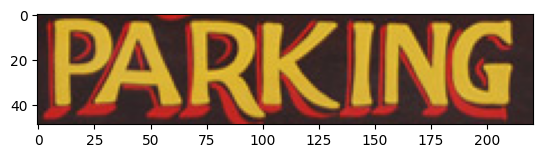

In [9]:
from PIL import Image

 # 推理过程
infer_file_path = './predict.png'

img_PIL = Image.open(infer_file_path).convert('RGB')
img = img_PIL.resize((100, 32), resample=3)
img = np.array(img, dtype=np.float32)
img = np.expand_dims(img, axis=0)  # (1,32,100,3)
img = np.transpose(img, [0, 3, 1, 2])  # (1,3,32,100)
img_tensor = Tensor.from_numpy(img)

model_predict = net(img_tensor)
preds_size = np.array([model_predict.shape[1]])
preds_index = np.argmax(model_predict, 2)
preds_index = np.reshape(preds_index, [-1])
preds_str = converter.decode(preds_index, preds_size)
print('Predict: ', preds_str)

plt.figure()
plt.imshow(img_PIL)
plt.show()